Makemore pt3
Use an RNN to model a character level language model.
[Video](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import IPython

In [2]:
# Mac OS GPU acceleration or CPU
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


In [3]:
# Load names from file
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [4]:
# Create vocab of characters to integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print('stoi', stoi)
print('itos', itos)
vocab_size = len(itos)


stoi {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Create dataset
block_size = 8 # char context length

def build_dataset(words):
    X, Y = [], [] # X = Data, Y = Target
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] # next char to be predicted and added to context
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

train_n = int(len(words) * 0.8)
dev_n = int(len(words) * 0.1)
test_n = len(words) - train_n - dev_n
random.shuffle(words)
train_words = words[:train_n]
dev_words = words[train_n:train_n+dev_n]
test_words = words[train_n+dev_n:]

Xtr, Ytr = build_dataset(train_words)
Xdev, Ydev = build_dataset(dev_words)
Xte, Yte = build_dataset(test_words)

In [6]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
class FlattenConsecutive:
  """Flatten a tensor of shape into n-gram like segments"""
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C  = x.shape
    x = x.view(B, T//self.n, C*self.n) # Karpathy likes to be as explicit as possible so error messages are more useful
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

n_embd = 20 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
torch.manual_seed(42)

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
#   layers[-1].gamma *= 0.1 # for batchnorm "weight"
  model.layers[-1].weight *= 0.1 # linear "weight"
  # # all other layers: apply gain
  # for layer in model.layers[:-1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 1.0 #5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

75447


In [7]:
# Get shape of model layers
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
print('Input tensor :', Xb.shape)

logits = model(Xb)
for layer in model.layers:
    print(layer.__class__.__name__, ':', layer.out.shape)

Input tensor : torch.Size([4, 8])
Embedding : torch.Size([4, 8, 20])
FlattenConsecutive : torch.Size([4, 4, 40])
Linear : torch.Size([4, 4, 128])
BatchNorm1d : torch.Size([4, 4, 128])
Tanh : torch.Size([4, 4, 128])
FlattenConsecutive : torch.Size([4, 2, 256])
Linear : torch.Size([4, 2, 128])
BatchNorm1d : torch.Size([4, 2, 128])
Tanh : torch.Size([4, 2, 128])
FlattenConsecutive : torch.Size([4, 256])
Linear : torch.Size([4, 128])
BatchNorm1d : torch.Size([4, 128])
Tanh : torch.Size([4, 128])
Linear : torch.Size([4, 27])


  0%|          | 51/200000 [00:00<06:34, 506.25it/s]

      0/ 200000: 3.2990


  5%|▌         | 10109/200000 [00:17<05:22, 589.47it/s]

  10000/ 200000: 2.4724


 10%|█         | 20091/200000 [00:35<05:27, 549.95it/s]

  20000/ 200000: 2.1944


 15%|█▌        | 30104/200000 [00:52<04:38, 609.99it/s]

  30000/ 200000: 2.0038


 20%|██        | 40083/200000 [01:08<04:18, 618.38it/s]

  40000/ 200000: 1.8565


 25%|██▌       | 50100/200000 [01:25<04:02, 618.41it/s]

  50000/ 200000: 1.9652


 30%|███       | 60094/200000 [01:41<03:46, 617.53it/s]

  60000/ 200000: 1.7866


 35%|███▌      | 70099/200000 [01:58<03:42, 585.09it/s]

  70000/ 200000: 1.3808


 40%|████      | 80103/200000 [02:14<03:16, 611.72it/s]

  80000/ 200000: 2.1422


 45%|████▌     | 90104/200000 [02:31<02:57, 617.76it/s]

  90000/ 200000: 2.1410


 50%|█████     | 100108/200000 [02:47<02:47, 596.35it/s]

 100000/ 200000: 1.7890


 55%|█████▌    | 110119/200000 [03:04<02:24, 623.09it/s]

 110000/ 200000: 2.0490


 60%|██████    | 120116/200000 [03:21<02:10, 610.27it/s]

 120000/ 200000: 1.6789


 65%|██████▌   | 130082/200000 [03:37<01:53, 615.72it/s]

 130000/ 200000: 1.7630


 70%|███████   | 140112/200000 [03:53<01:36, 619.42it/s]

 140000/ 200000: 2.0722


 75%|███████▌  | 150112/200000 [04:10<01:20, 619.06it/s]

 150000/ 200000: 1.7443


 80%|████████  | 160079/200000 [04:26<01:05, 611.08it/s]

 160000/ 200000: 1.9120


 85%|████████▌ | 170078/200000 [04:42<00:50, 589.07it/s]

 170000/ 200000: 1.3434


 90%|█████████ | 180079/200000 [04:59<00:32, 609.12it/s]

 180000/ 200000: 1.5445


 95%|█████████▌| 190087/200000 [05:16<00:16, 610.72it/s]

 190000/ 200000: 1.9450


100%|██████████| 200000/200000 [05:32<00:00, 601.22it/s]


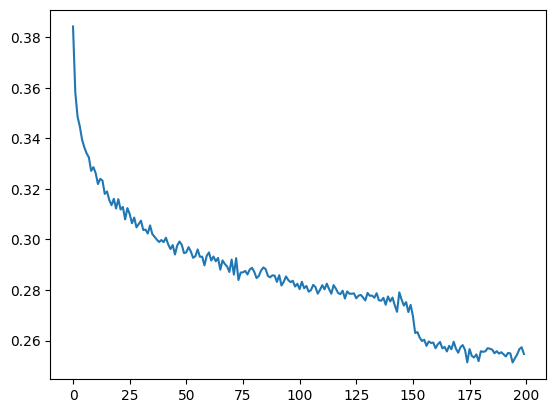

In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in tqdm(range(max_steps)):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

lossi_smooth = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(lossi_smooth)  

In [9]:
# Put layers into eval mode
for layer in model.layers:
    layer.training = False
# Evaluation
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'- {split} loss: {loss.item():.4f}')
split_loss('train')
split_loss('dev')
split_loss('test')

- train loss: 1.7784
- dev loss: 1.9862
- test loss: 1.9889


With BatchNorm bug, WaveNet with n_hidden=68

- train loss: 1.9445
- dev loss: 2.0197
- test loss: 2.0255

Fixed BatchNorm bug, WaveNet with n_hidden=68
- train loss: 1.9125
- dev loss: 2.0082
- test loss: 2.0159

Expanded params to 72K from 22K, WaveNet with n_hidden=124, n_emb=20
- train loss: 1.7691
- dev loss: 1.9859
- test loss: 1.9991

In [10]:
# Seeing results
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))

desmphina.
trin.
willip.
misgotelia.
leguani.
dasibr.
eliana.
farros.
treope.
kianna.
neveon.
alayna.
loan.
teon.
karsyn.
vsachi.
antoni.
jakaazie.
kamir.
aktan.
